<a name="top"></a><img src="imgs/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

运行SpinalHDL代码之前，务必加载SpinalHDL的库 
（**注**：*第一次运行时需要下载库，可能会有点慢，请耐心等待*）

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

## 写在之前
这是Spinal的在线教程，没有介绍Scala的基本用法，假设你已经具备了基本的Scala知识，如果要学习scala，Programing-in-Scala是一本比较推荐的好书。  

**为什么要写这个教程** ：
SpinalHDL的一些库更符合硬件设计的概念，并且有非常好的文档，作者本人有良好的硬件开发背景。所以我希望把文档上的例子以比较方便的方式介绍给大家，绝大多数来自于SpinalHDL的官方文档，也有一些自己补充。同时也鼓励大家把自己一些实用好的例子用简单清晰的方式介绍给大家。

关于我为什么从chisel切换到SpinalHDL，我有在这里回答，中文请点击这里。

开启精彩的Spinal之旅

## 两个有用的函数   

如果你想直接在Jupyter-Notebook里打印RTL代码：

- **`showRtl(new MyTop)`** 打印RTL代码,默认打印Verilog，
- **`showRtl(new MyTop,VHDL)`** 来打印VHDL代码，或者更为简便的方式 **`showVhdl(new myTop)`**

SpinalHDL默认的生成RTL代码的函数为

- **`SpinalVerilog(new MyTop)`** 会在当前目录下生成Verilog文件
- **`SpinalVhdl(new MyTop)`** 会在当前目录下生成VHDL文件

如果要指定目录:  
**`SpinalConfig(mode = Verilog, targetDirectory="rtl/").generate(new MyTop)`**

## 一个简单的加法器

一个简单的例子,参数化位宽的加法器,输入位宽定义，输出位宽自行推断。


In [ ]:
class Adder(width: Int) extends Component{
  val a = in(UInt(width bits))
  val b = in(UInt(width bits))
  val c = out(UInt()) 
  c := a + b
}
showRtl(new Adder(8))

## 如何生成一个Soc
在Spinal里是非常简单的一件事情，可能是需要10s的时间，一行代码

In [ ]:
import spinal.lib.soc.pinsec._
SpinalVerilog(new Pinsec(500 MHz))

以上会在当前目录下生成 **Pinsec.v** 的Soc，包括一个完整的Riscv处理器，MEM， APB接口，Timer，是一个五脏俱全的完整的SOC。
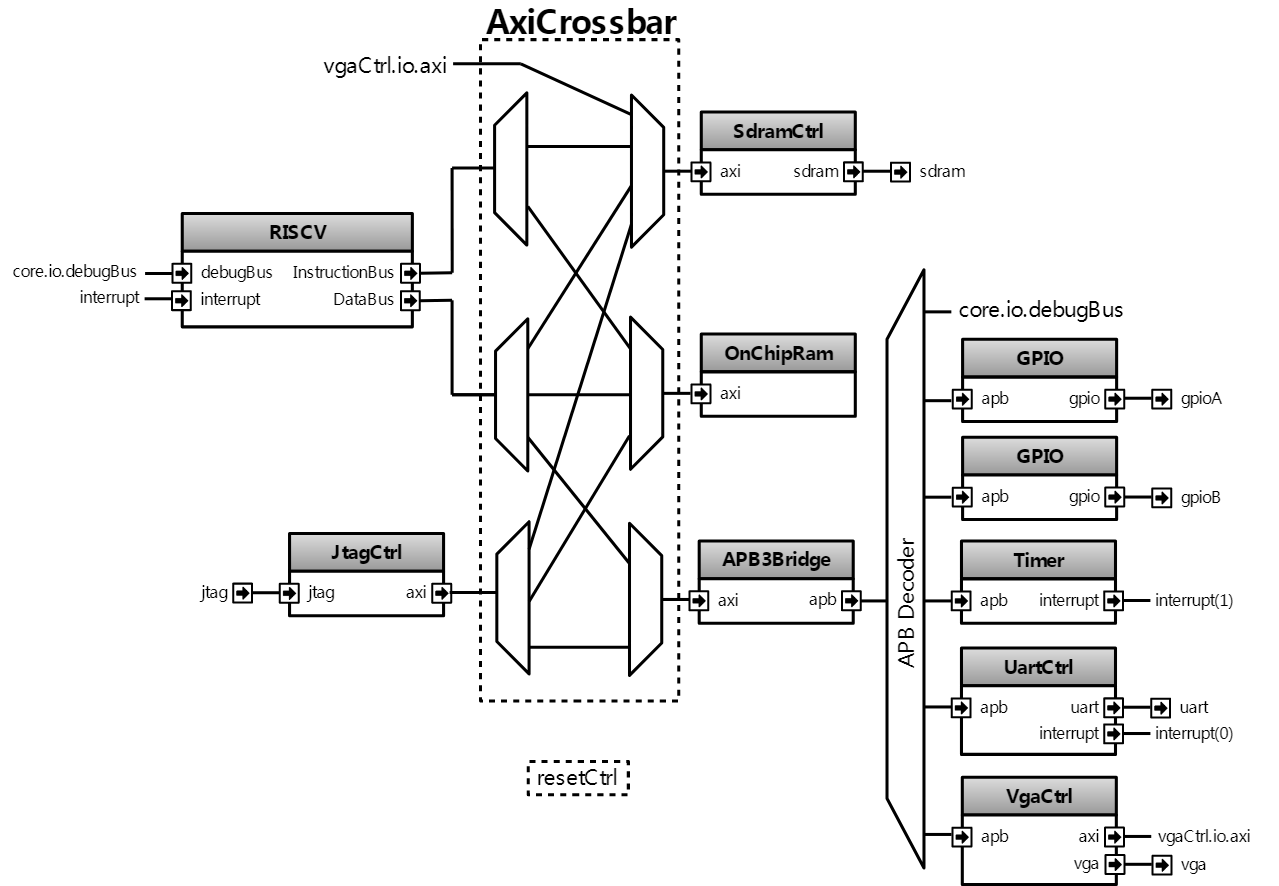
你或许会有一些疑问，这么简单它到底生成了什么，我能不能自己定制参数规格，完全没有问题

### 首先自配置Cpu


In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.amba4.axi._
import spinal.lib.com.jtag.Jtag
import spinal.lib.com.uart.{Uart, UartCtrlGenerics, UartCtrlMemoryMappedConfig, Apb3UartCtrl}
import spinal.lib.cpu.riscv.impl.Utils.BR
import spinal.lib.cpu.riscv.impl.build.RiscvAxi4
import spinal.lib.cpu.riscv.impl.extension.{BarrelShifterFullExtension, DivExtension, MulExtension}
import spinal.lib.cpu.riscv.impl._
import spinal.lib.graphic.RgbConfig
import spinal.lib.graphic.vga.{Vga, Axi4VgaCtrlGenerics, Axi4VgaCtrl}
import spinal.lib.io.TriStateArray
import spinal.lib.memory.sdram._
import spinal.lib.system.debugger.{JtagAxi4SharedDebugger, SystemDebuggerConfig}

val myCpuConfig = RiscvCoreConfig(
        pcWidth = 32,
        addrWidth = 32,
        startAddress = 0x00000000,
        regFileReadyKind = sync,
        branchPrediction = dynamic,
        bypassExecute0 = true,
        bypassExecute1 = true,
        bypassWriteBack = true,
        bypassWriteBackBuffer = true,
        collapseBubble = false,
        fastFetchCmdPcCalculation = true,
        dynamicBranchPredictorCacheSizeLog2 = 7
      )

myCpuConfig.add(new MulExtension)
myCpuConfig.add(new DivExtension)
myCpuConfig.add(new BarrelShifterFullExtension)

### 扩展CPU
```
myCpuConfig.add(new MulExtension)
myCpuConfig.add(new DivExtension)
myCpuConfig.add(new BarrelShifterFullExtension)
```

如果你用Spinal开发了浮点,或者矢量处理扩展，可以用这种方式扩展它。  

```
myCpuConfig.add(new myFloatExtension)
myCpuConfig.add(new myVectorExtension) 
```

### 还配置iCache

In [ ]:
val myiCacheConfig = InstructionCacheConfig(
        cacheSize    = 4096,
        bytePerLine  = 32,
        wayCount     = 1,  //Can only be one for the moment
        wrappedMemAccess = true,
        addressWidth = 32,
        cpuDataWidth = 32,
        memDataWidth = 32
      )

###  最后配置Soc

将上面的riscvCpu配置，iCache的配置加入到Soc的配置当中，这样我们就得到了一个经过**定制的Soc系统**

In [ ]:
val mySocConfig = PinsecConfig(
    axiFrequency   = 100 MHz,
    onChipRamSize  = 4 KiB,
    sdramLayout    = IS42x320D.layout,
    sdramTimings   = IS42x320D.timingGrade7,
    cpu            = myCpuConfig,
    iCache         = myiCacheConfig)

SpinalVerilog(new Pinsec(mySocConfig))

### 一些全局配置
我们也可以全局配置SpinalConfig，比如改为我们习惯的异步复位，低电平有效

In [ ]:
object MySpinalConfig extends SpinalConfig(
    defaultConfigForClockDomains = ClockDomainConfig(
                                         resetKind = ASYNC,
                                         clockEdge = RISING, 
                                         resetActiveLevel = LOW)
)
MySpinalConfig.generateVerilog(new Pinsec(100 MHz))

In [ ]:
val freq = 100 MHz
val time = 10 ms
//val time = 100 $ 100.$() =  return  RBM(100)
val cycle = time * freq 

In [ ]:
SpinalVerilog(new pinsec)